# Evaluating Mask-RCNN - Multi-class

In this notebook I evaluate the multi-class Mask-RCNN model used to detect watermelons, canteloupes and honeydews using the model trained Google Colabs. [Training model](./multi_maskRCNN_colab_train.ipynb)

The model is currently in its third iteration and is still a work in progress. 
At the end of the notebook are detections on my test preiction images. The final aim is to make an app where the user can upload their own images or take a photo and the model detects the melon and type. The test images are harder than what I would expect a user to upload so that I can see where improvements need to made and see where the model is struggling. Details of the changes made are in the Training model link above. 


**Note: Some of the functions in these cells may need to run on colabs due to the resources required. I have put a warning before these cells.**

Parts of this script were adapted from the [Matterport Balloons Example](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)  

In [40]:
!git clone https://github.com/matterport/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [41]:
#RUN GPU
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

"""
#RUN TPU
%tensorflow_version 1.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
"""

Found GPU at: /device:GPU:0


'\n#RUN TPU\n%tensorflow_version 1.x\nimport tensorflow as tf\nprint("Tensorflow version " + tf.__version__)\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n'

In [0]:
import os
os.chdir('Mask_RCNN')


In [43]:
!ls

assets	LICENSE      mrcnn	requirements.txt  setup.cfg
images	MANIFEST.in  README.md	samples		  setup.py


In [44]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn

In [0]:
import mrcnn
import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn import utils
from mrcnn.model import MaskRCNN, load_image_gt, mold_image, log

import numpy as np
import colorsys
import argparse
import random
import os
import sys
import time
import json
import skimage
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
homedir='/content/drive/My Drive/Colab Data/'
datadir=homedir+'data/RCNN_test_all/'

In [48]:
"""
class myMaskRCNNConfig(Config):
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
 
    # number of classes (we would normally add +1 for the background)
    NUM_CLASSES = 3+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 240
    
    # Learning rate (reduced to stop NaN losses)
    #LEARNING_RATE=0.006
    LEARNING_RATE=0.001
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.5
    
    # setting Max ground truth instances
    
    MAX_GT_INSTANCES=50

"""

class myMaskRCNNConfig(Config):
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
 
    # number of classes (we would normally add +1 for the background)
    NUM_CLASSES = 3+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 240
    
    # Learning rate (reduced to stop NaN losses)
    #LEARNING_RATE=0.006
    LEARNING_RATE=0.001
    
    # Skip detections with < 90% confidence
    #DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_MIN_CONFIDENCE = 0.5
    
    # setting Max ground truth instances
    #MAX_GT_INSTANCES=10
    MAX_GT_INSTANCES=50

    #ADDED TO IMPROVE MULTICLASS
    # ROIs kept after non-maximum suppression (training and inference)
    #Added 1000 to ROIS found. If I can find more potential melons I can filter
    #them afterwards. 
    POST_NMS_ROIS_TRAINING = 3000
    POST_NMS_ROIS_INFERENCE = 2000 

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    #Added 0.1
    RPN_NMS_THRESHOLD = 0.8

    # How many anchors per image to use for RPN training
    # Doubled the number of anchors. Will reduce speed.
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512

    # Length of square anchor side in pixels
    #Added 16 to help find small melons
    #Won't work when using COCO Dataset
    #RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256, 512)

config = myMaskRCNNConfig()
config.display()


"""
DEFINE THE TRAINING AND VALIDATION SETS HERE
"""
check=[]
class MelonDataset(utils.Dataset):

    def load_dataset(self, dataset_dir):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        #             (source (dataset), class (integer), class name)
        self.add_class("melon", 1, "watermelon")
        self.add_class("melon", 2, "canteloupe")
        self.add_class("melon", 3, "honeydew")
      

        # Train or validation dataset?
        #assert subset in ["train", "test"]
        #dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(homedir, "model_data/all_melon_annot.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            if a['filename'] in os.listdir(dataset_dir):
                # Get the x, y coordinates of points of the polygons that make up
                # the outline of each object instance. These are stored in the
                # shape_attributes (see json format above)
        
                if type(a['regions']) is dict:
                        polygons = [r['shape_attributes'] for r in a['regions'].values()]
                        melon_type = [s['region_attributes'] for s in a['regions'].values()]
                        #print('\n\n1:\n\n'+polygons)
                else:
                        polygons = [r['shape_attributes'] for r in a['regions']]
                        melon_type = [s['region_attributes'] for s in a['regions']]
                        #polygons=polygons[0]
                        #print('\n\n2:\n\n'+str(polygons.items()))

    
                #polygons=polygons[0]
        
                # load_mask() needs the image size to convert polygons to masks.
                # Unfortunately, VIA doesn't include it in JSON, so we must read
                # the image. This is only managable since the dataset is tiny.
                image_path = os.path.join(dataset_dir, a['filename'])
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]
    
                self.add_image(
                    "melon",
                    image_id=a['filename'],  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons,
                    melon_type=melon_type)

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        
        Returns:
        
        masks: A bool array of shape [height, width, instance count] with
               one mask per instance.
        
        class_ids: a 1D array of class IDs of the instance masks.
        
        """
        # If not a melon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "melon":
            print('not a melon!')
            return super(self.__class__, self).load_mask(image_id)

        #class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        #if info["polygons"]["name"]=="polyline":
        class_id=[]
        #print(len(info["polygons"]))
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            m_type=(list(info["melon_type"][i]['type'].keys()))
            class_id.append(self.class_names.index(m_type[0]))
        class_ids = np.array(class_id, dtype=np.int32)
        #class_ids = np.array(class_ids, dtype=np.int32)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, class_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "melon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [49]:
# prepare train set
train_set = MelonDataset()
train_set.load_dataset(datadir+'/train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = MelonDataset()
test_set.load_dataset(datadir+'/test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 240
Test: 60


In [50]:
train_set.class_info

[{'id': 0, 'name': 'BG', 'source': ''},
 {'id': 1, 'name': 'watermelon', 'source': 'melon'},
 {'id': 2, 'name': 'canteloupe', 'source': 'melon'},
 {'id': 3, 'name': 'honeydew', 'source': 'melon'}]

## Check the contents of the datasets:

In [51]:
print("Image Count: {}".format(len(train_set.image_ids)))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 240
Class Count: 4
  0. BG                                                
  1. watermelon                                        
  2. canteloupe                                        
  3. honeydew                                          


# Display Sample Images
Check that the datasets contain the correct masks.
Loading images after training is only showing one mask per image andno predictions.

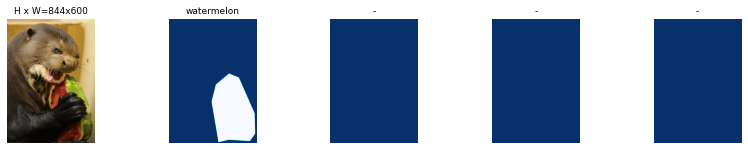

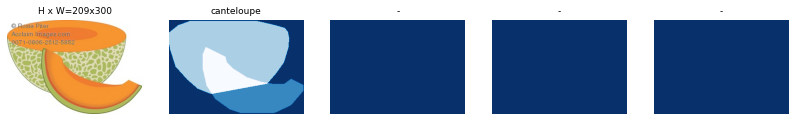

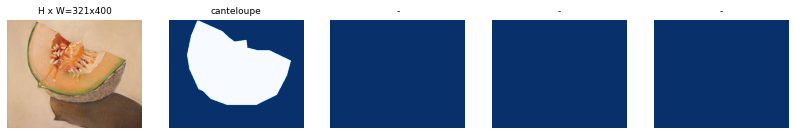

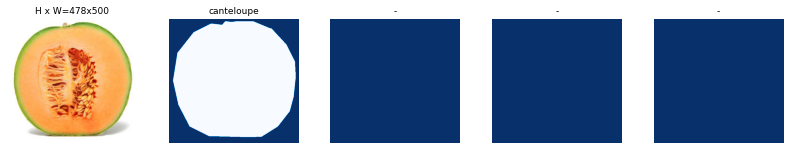

In [52]:

# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

# Prepare Prediciton Model:
We use the inference model to make predicitons

In [53]:
class PredictionConfig(myMaskRCNNConfig):
    NAME = "MaskRCNN_cfg"
    NUM_CLASSES = 3 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = PredictionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Load Saved Models from Google Drive:
***Note: Models not available on github.  
I will provide links in the notebook soon. 
Place model files in ./model_data/**

In [0]:
#time_str='20200227T1210'
#ime_str='20200322T1416'
time_str='20200322T2009'
weights_fname =homedir+'model_data/weights_all_melon_'+time_str+'.h5'
history_fname =homedir+'model_data/history_all_melon_'+time_str+'.json'

with open(history_fname, 'r') as file:
    history=file.read()
# parse file
hist_dict = json.loads(history)

## Load the Inference Model:

In [0]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights(weights_fname, by_name=True)

# Training Evaluation
Let's first have a look at how the model performed during training using the history data.


In [0]:
def plot_training(metric):
  fig=plt.figure()
  plt.plot(hist_dict[metric], c='blue')
  plt.plot(hist_dict['val_'+metric], c='red')
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'])
  plt.show()

metrics to choose from:

In [57]:
for metric in hist_dict.keys():
  print(metric)

val_loss
val_rpn_class_loss
val_rpn_bbox_loss
val_mrcnn_class_loss
val_mrcnn_bbox_loss
val_mrcnn_mask_loss
loss
rpn_class_loss
rpn_bbox_loss
mrcnn_class_loss
mrcnn_bbox_loss
mrcnn_mask_loss


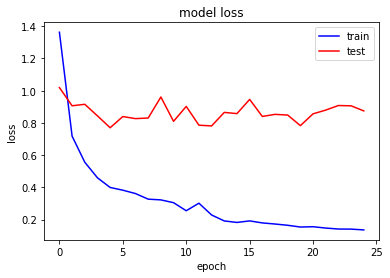

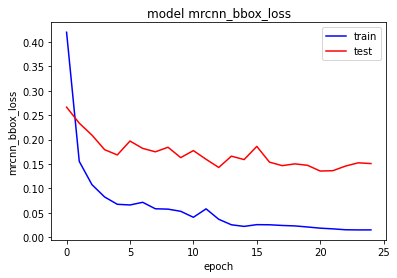

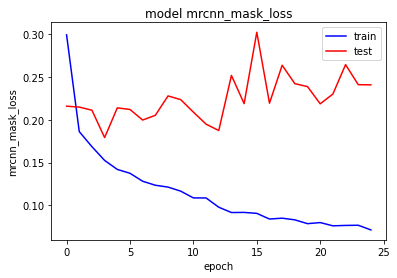

In [58]:
plot_training('loss')
plot_training('mrcnn_bbox_loss')
plot_training('mrcnn_mask_loss')



We have looked at the loss, bounding box loss and mask loss during training over 25 epochs. For the app usage I'm mainly interested in the mrcnn_bbox_loss (middle plot). The model still appears to be overfitting. I have lowered the learning rate and increased the number of epochs since the initial run with a small improvement. The next step is to examine how the config changes affect the loss and see if I can figure out which parameters will improve the model performance. 

## Evaluate the Model:
***May be slow to run on a local machine**

First we will look at the mean absolute precision (mAP). This is calculated by dividing the overlapping area of the predicted and actual bounding boxes by the total area of both boxes. 

In [0]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
  APs = list()
  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    scaled_image = mold_image(image, cfg)
    sample = np.expand_dims(scaled_image, 0)
    yhat = model.detect(sample, verbose=0)
    r = yhat[0]
    AP, _, _, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
  mAP = np.mean(APs)
  return mAP

In [60]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.948
Test mAP: 0.747


|Set|mAP Score|
|:---:|:---:|
|Train|94.8%|
|Test|74.7%|

We achieved 94.8% for the training set and 74.7% for the test set. This is an improvement over the original single class model of around 3% in training and 12% on the test set.

## Plot Actual vs. Predicted:
***May be slow to run on a local machine**

Now we can look at how the model perfomed on some of the annotated test set predictions

In [0]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = np.expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		plt.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		plt.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Predicted')
		ax = plt.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	plt.show()

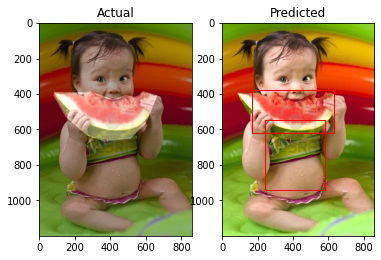

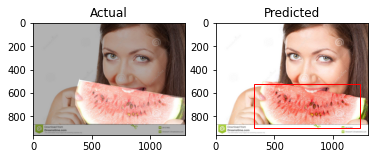

In [62]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg, n_images=1)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg, n_images=1)


# New Image Predictions
Now to predict some new images. 

I've increased the probability threshold to 80% to filter down some of the results. This will likely under predict some images, but should give definite predicitons for the key parts of the image.

In [0]:
def prediction(file, model, confidence=0.95):
    image = skimage.io.imread(file)
    results = model.detect([image], verbose=1)[0]
    fig=plt.figure(figsize=(12,10))
    plt.plot()

    plt.imshow(image)
    plt.title('Predicted\n' + file.split('/')[-1], fontsize=16)
    ax = plt.gca()
    # Define the boxes with probabilies to keep
    keep=np.where(results['scores'] > confidence)
    keep=keep[0]
    
    #(image, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
    cmap=['white', 'red', 'darkorange', 'gold']
    for box in keep:
        y1, x1, y2, x2 = results['rois'][box]
        c_index=results['class_ids'][box]
        melon=train_set.class_names[c_index]
        score=results['scores'][box]
        annotation = ('%s: %.2f' % (melon, score))
        color = cmap[c_index]
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color=color)
        ax.add_patch(rect)
        ax.text(x1, y1, annotation, fontsize=12, color=color)
        ax.axis('off')
    plt.show()

    return results

Processing 1 images
image                    shape: (808, 634, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


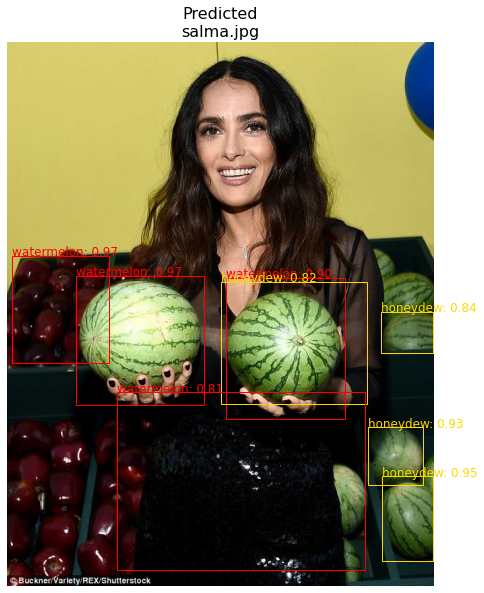

Processing 1 images
image                    shape: (334, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


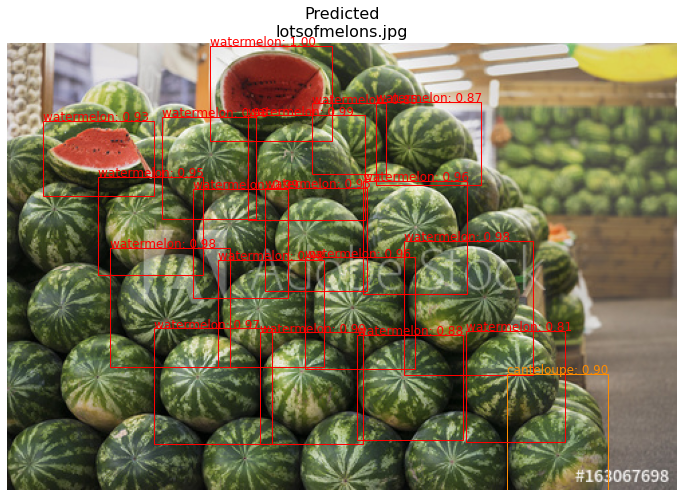

Processing 1 images
image                    shape: (1300, 1266, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  141.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


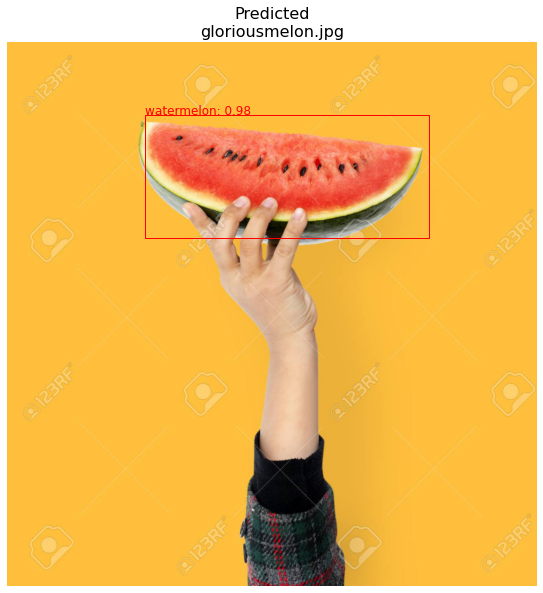

Processing 1 images
image                    shape: (1080, 1000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


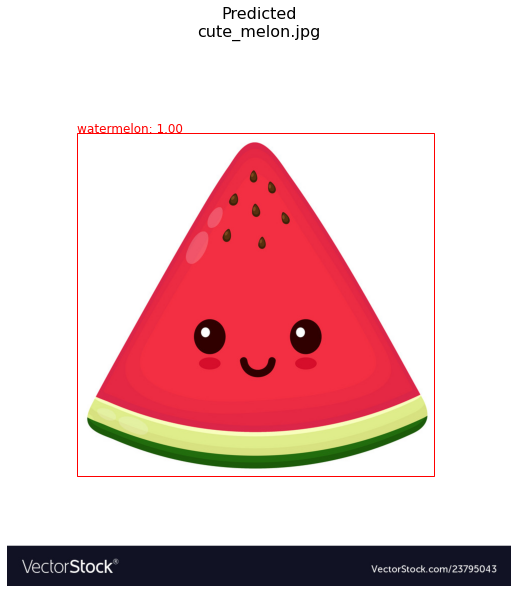

Processing 1 images
image                    shape: (420, 600, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


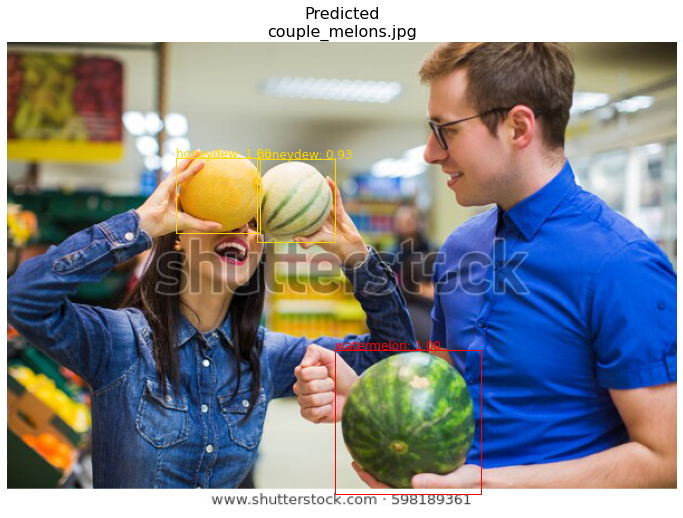

Processing 1 images
image                    shape: (866, 1300, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


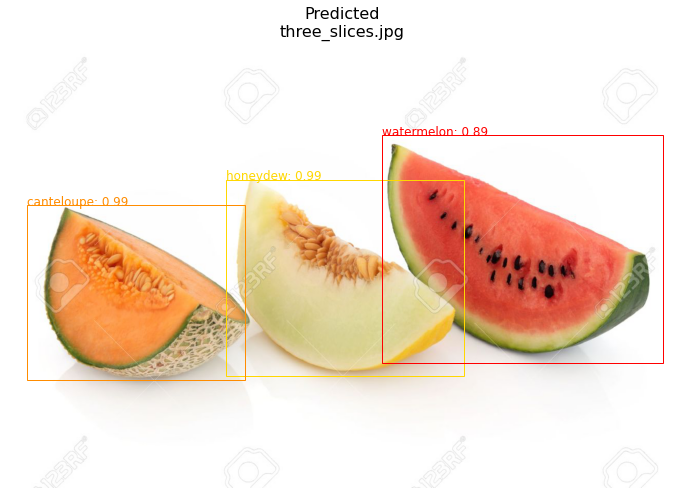

Processing 1 images
image                    shape: (1300, 874, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


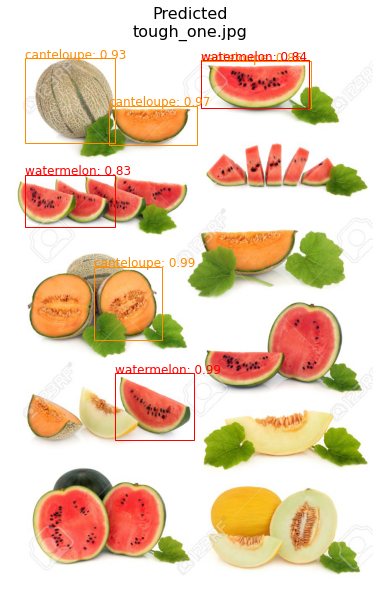

In [64]:
predictions=[]
filedir=homedir+'data/RCNN_test_all/predict/'
i=1
for file in os.listdir(filedir):
    filepath=filedir+file
    predictions.append(prediction(filepath, model, 0.8));

## Predictions Analysis
In the images with an obvious melon which is the focus of the image the model is predicting well. These are the types of images I would expect a user to take. The first image of Salma Hayek makes a number of false predictions. The main watermelons are detected with high confidence but the apples and Salma's dress are predicted as watermelons and the background watermelons are predicted as honeydews. 
In the final image with lots of small images of melons together the model misses a lot of predictions, howevere, the predictions it does make are accurate. 

My focus for improvement will be on increasing the number of predictions made to try to capture as many melons in the final image as possible. I will also re-examine my training images and try running with data augmentation. 


## Image Segmentation
We can use the build-in mrcnn.visualize module to pull out the predicted masks with their probabilities and separate these from the image.

This is using the 0.5 detection threshold defined in the config. 

Processing 1 images
image                    shape: (808, 634, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


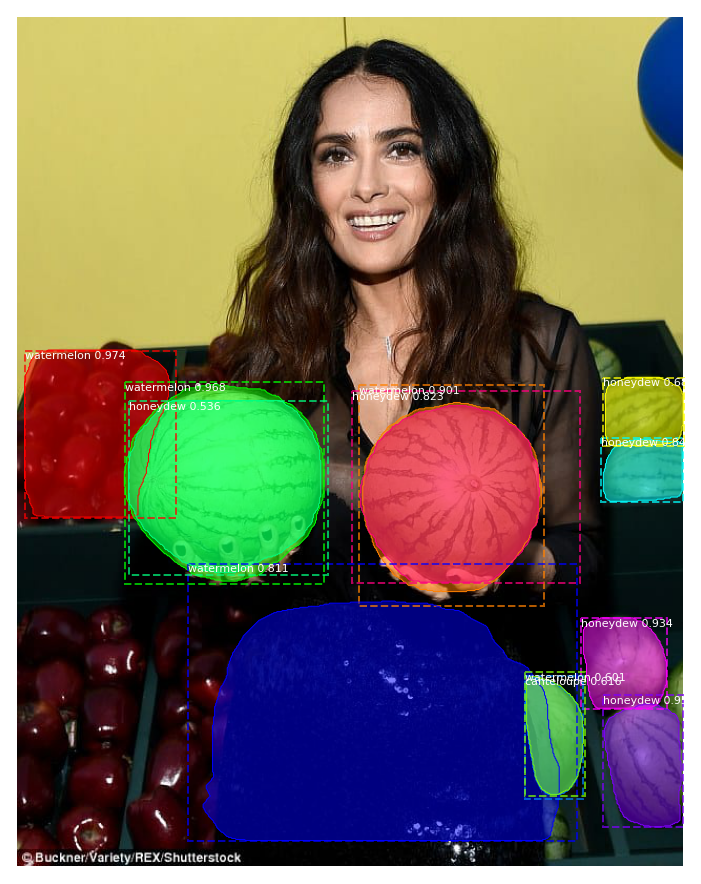

In [66]:
file=homedir+'data/RCNN_test_all/predict/salma.jpg'
image = skimage.io.imread(file)
class_names=train_set.class_names
p = model.detect([image], verbose=1)[0]
visualize.display_instances(image, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

## Extract Segmentations

In [67]:
mask = p['masks']
mask = mask.astype(int)
mask.shape
#mask = 1-mask


(808, 634, 12)

In [0]:
def segment(image, p, i):
  mask = p['masks'][:,:,i]
  bbox = p['rois'][i]
  mask = np.stack((mask,)*3, axis=-1)
  mask = mask.astype('uint8')
  bg = 255 - mask * 255
  mask_img = image*mask
  result = mask_img+ bg
  return result[bbox[0]:bbox[2], bbox[1]:bbox[3]]

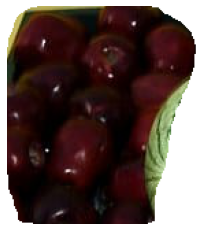

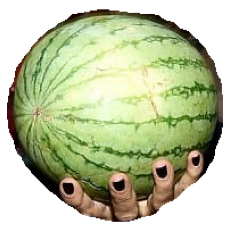

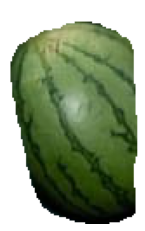

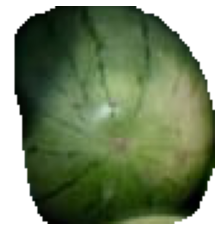

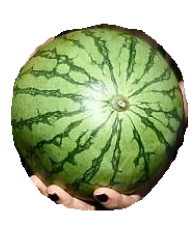

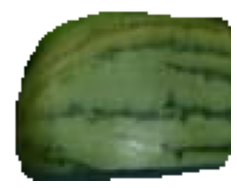

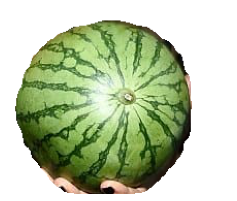

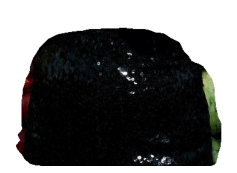

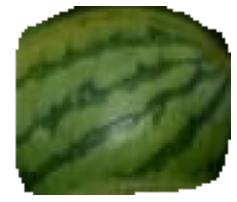

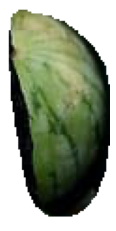

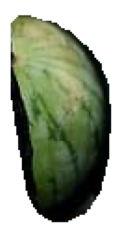

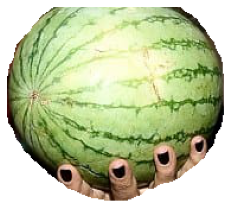

In [69]:
for i in range(mask.shape[2]):
  segmentation = segment(image, p, i)
  fig=plt.figure(figsize=(4,4))
  plt.axis('off')
  plt.imshow(segmentation)
